## Import Library dan data 

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np 
import time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from hpbandster_sklearn import HpBandSterSearchCV
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH


from skopt.space import Real,Integer


from hpbandster.optimizers import BOHB

In [24]:
X_bank=pd.read_csv('dataset/X_bank_preprocessed.csv').to_numpy()
y_bank=pd.read_csv('dataset/y_bank_preprocessed.csv').to_numpy().ravel()

X_credit=pd.read_csv('dataset/X_credit.csv').to_numpy()
y_credit=pd.read_csv('dataset/y_credit.csv').to_numpy().ravel()

X_income=pd.read_csv('dataset/X_income.csv').to_numpy()
y_income=pd.read_csv('dataset/y_income.csv').to_numpy().ravel()

## Model dan Search Space of Hyperparameter

XGBoost : 
- hyper_space_1  : untuk GS
- hyper_space_2  : untuk RS
- hyper_space_3  : untuk BO
- hyper_space_4  : untuk BOHB

LightGBM :
- hyper_space_5  : untuk GS
- hyper_space_6  : untuk RS
- hyper_space_7  : untuk BO
- hyper_space_8  : untuk BOHB

CatBoost :
- hyper_space_9  : untuk GS
- hyper_space_10 : untuk RS
- hyper_space_11 : untuk BO
- hyper_space_12 : untuk BOHB

### Inisialisasi Model 

In [25]:
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

model_x=XGBClassifier()
model_l=LGBMClassifier()
model_c=CatBoostClassifier()

### hyper_space

In [26]:
hyper_space_1={
    'eta': [0.01,0.5], 
    'subsample': [0.1,0.8],
    'max_depth': [2,8,14,20,26],
    'gamma':[0.001,0.4],
    'min_child_weight':[2,5,7,11,15]
}

hyper_space_2={
    'eta': list(np.logspace
                (np.log10(0.001),np.log10(1),base=10,num=1000)), 
    'subsample': list(np.linspace(0.1,1,100)),
    'max_depth':list(range(1,101)),
    'gamma':list(np.linspace(0.001,2,100)),
    'min_child_weight':list(range(1,101))
}

hyper_space_3={
    'eta': Real(0.001,1,'log-uniform'), 
    'subsample': Real(0.1,1,'uniform'),
    'max_depth': Integer(1,100,'uniform'),
    'gamma': Real(0.001,2,'uniform'),
    'min_child_weight': Integer(1,100,'uniform')
}

def hyper_space_4(benih):
    cs = CS.ConfigurationSpace(seed=benih)
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('eta',lower=0.001,upper=1,log=True))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('subsample',lower=0.1,upper=1,log=False))
    cs.add_hyperparameter(CSH.UniformIntegerHyperparameter
                          ('max_depth',lower=1,upper=100,log=False))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('gamma',lower=0.001,upper=2,log=False))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('min_child_weight',lower=1,upper=100,log=False))
    return cs 

In [27]:
hyper_space_5={
    'max_depth': [10,20,30,40,50],
    'min_data_in_leaf':[10,30,50,70,90],
    'num_leaves': [10,40],
    'learning_rate': [0.01,0.5], 
    'bagging_fraction':[0.1,0.9]
}

hyper_space_6={
    'max_depth': list(range(1,101)),
    'min_data_in_leaf':list(range(1,101)),
    'num_leaves': list(range(10,101)),
    'learning_rate': list(np.logspace
                          (np.log10(0.001),np.log10(1),base=10,num=1000)),
    'bagging_fraction':list(np.linspace(0.1,1,100))
}

hyper_space_7={
    'max_depth': Integer(1,100,'uniform'),
    'min_data_in_leaf': Integer(1,100,'uniform'),
    'num_leaves': Integer(10,100,'uniform'),
    'learning_rate': Real(0.001,1,'log-uniform'),
    'bagging_fraction':Real(0.1,1,'uniform')    
}

def hyper_space_8(benih):
    cs = CS.ConfigurationSpace(seed=benih)
    cs.add_hyperparameter(CSH.UniformIntegerHyperparameter
                          ('max_depth',lower=1,upper=100,log=False))
    cs.add_hyperparameter(CSH.UniformIntegerHyperparameter
                          ('min_data_in_leaf',lower=1,upper=100,log=False))
    cs.add_hyperparameter(CSH.UniformIntegerHyperparameter
                          ('num_leaves',lower=1,upper=100,log=False))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('learning_rate',lower=0.001,upper=1,log=True))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('bagging_fraction',lower=0.1,upper=1,log=False))
    
    return cs 

In [28]:
hyper_space_9={
    'max_depth': [2,5,8,11,14],
    'learning_rate': [0.01,0.1],
    'l2_leaf_reg':[1,6,11,16,21],
    'bagging_temperature':[0.5,20],
    'random_strength':[0.5,20]
}

hyper_space_10={
    'max_depth': list(range(1,17)),
    'learning_rate': list(np.logspace
                          (np.log10(0.001),np.log10(1),base=10,num=1000)),
    'l2_leaf_reg':list(np.linspace(1,50,100)),
    'bagging_temperature':list(np.linspace(1,50,100)),
    'random_strength':list(np.linspace(1,50,100))
}

hyper_space_11={
    'max_depth': Integer(1,16,'uniform'),
    'learning_rate': Real(0.001,1,'log-uniform'),
    'l2_leaf_reg': Real(1,50,'uniform'),
    'bagging_temperature':Real(1,50,'uniform'),
    'random_strength':Real(1,50,'uniform')
}

def hyper_space_12(benih):
    cs = CS.ConfigurationSpace(seed=benih)
    cs.add_hyperparameter(CSH.UniformIntegerHyperparameter
                          ('max_depth',lower=1,upper=16,log=False))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('learning_rate',lower=0.001,upper=1,log=True))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('l2_leaf_reg',lower=1,upper=50,log=False))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('bagging_temperature',lower=1,upper=50,log=False))
    cs.add_hyperparameter(CSH.UniformFloatHyperparameter
                          ('random_strength',lower=1,upper=50,log=False))
    return cs 

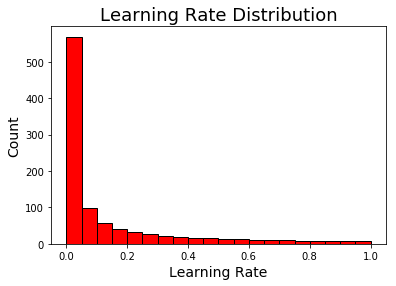

In [29]:
# distribusi untuk eta atau learning rate 
import seaborn as sns

# Learning rate histogram
plt.hist(hyper_space_2['eta'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

In [8]:
# Check number of values in each category
a,b,c = 0,0,0


for x in hyper_space_2['eta']:
    # Check values
    if x >= 0.001 and x < 0.01:
        a += 1
    elif x >= 0.01 and x < 0.1:
        b += 1
    elif x >= 0.1 and x < 1:
        c += 1

print('There are {} values between 0.001 and 0.01'.format(a))
print('There are {} values between 0.01 and 0.1'.format(b))
print('There are {} values between 0.1 and 1'.format(c))

There are 333 values between 0.001 and 0.01
There are 333 values between 0.01 and 0.1
There are 333 values between 0.1 and 1


## HPO Algorithm

In [30]:
def random_search(X,y,model,parameter,iterasi,evalscore,seed):
    auc=[]
    std=[]

    random_search=RandomizedSearchCV(
                   model,
                   parameter, 
                   n_iter=iterasi, 
                   scoring=evalscore, 
                   n_jobs=-1, 
                   cv=5, 
                   random_state=seed,
                   verbose= 1)
    
    random_search.fit(X,y)

    best_index=random_search.best_index_
    auc.append(random_search.cv_results_['mean_test_score'])
    std.append(random_search.cv_results_['std_test_score'])
    best_param=random_search.best_params_
    
    return auc,std,best_index,best_param

def grid_search(X,y,model,parameter,evalscore):
    auc=[]
    std=[]

    grid_search=GridSearchCV(
                model,
                parameter,
                scoring = evalscore,
                n_jobs = -1,
                cv = 5,
                verbose= 1
    )
    
    grid_search.fit(X,y)

    best_index=grid_search.best_index_
    auc.append(grid_search.cv_results_['mean_test_score'])
    std.append(grid_search.cv_results_['std_test_score'])
    best_param=grid_search.best_params_
    
    return auc,std,best_index,best_param

def bayes_opt(X,y,model,parameter,iterasi,evalscore,seed):
    
    auc=[]
    std=[]

    bayes_search= BayesSearchCV(
                   model, 
                   parameter, 
                   n_jobs=-1, 
                   n_iter=iterasi,
                   scoring=evalscore,
                   cv=5,
                   random_state=seed,
                   verbose= 0,
                   iid=True 
    )
    
    bayes_search.fit(X,y)
    
    best_index=bayes_search.best_index_
    auc.append(bayes_search.cv_results_['mean_test_score'])
    std.append(bayes_search.cv_results_['std_test_score'])
    best_param=bayes_search.best_params_
    
    return auc,std,best_index,best_param

# def bohb(X,y,model,parameter,iterasi,evalscore):
#     auc=[]
#     std=[]
    
#     bohb_search=HpBandSterSearchCV(
#                 model,
                
#                 )
    
# def bohb_2():
#     NS=hpns.NameServer(run_id='example1',host='127.0.0.1',port=None)
#     NS.start()
#     w=MyWorker(sleep_interval=0,nameserver='127.0.0.1',run_id='example1')
#     w.run(background=True)
#     bohb=BOHB(configspace=w.get_configspace(),
#               run_id='example1',
#               nanme)

## Visualisasi Hasil

In [31]:
def print_hasil(iteration,auc,std,best_param,best_index):
    print("Iterasi: ",iteration)
    print("All AUC: ",auc,'\n')
    print("mean AUC : ", np.mean(auc))
    print("All std: ",std,'\n')
    print("Best Hyperparameter: ",best_param,'\n')
    print("Best index/iterasi : ",best_index)
    print("Best AUC :",auc[0][best_index],"( std:",std[0][best_index],")",'\n')

def scatter_plot_1(x,y,best_index,iteration,label_x,label_y):
    fig=plt.figure(figsize=(20,5))
    plt.scatter(x,y)
    plt.plot(x[best_index],y[best_index],marker='*',markersize=22,markerfacecolor='yellow')
    fig=plt.xticks(range(1,iteration+1))
    fig=plt.xlabel(label_x)
    fig=plt.ylabel(label_y)
    fig=plt.xticks(range(0,210,10))
    
def line_plot_1(iteration,label_x,label_y):
    fig=plt.figure(figsize=(20,5))
    x=range(1,iteration+1)
    y=auc[0]
    error=std[0]
    plt.plot(x,y,'or')
    plt.plot(x,y,color='gray')
    plt.plot(x[best_index],y[best_index],marker='*',markersize=22,markerfacecolor='yellow')
    fig=plt.xticks(range(1,iteration+1))
    fig=plt.xlabel(label_x)
    fig=plt.ylabel(label_y)
    fig=plt.xticks(range(0,210,10))
    
def line_plot_2(x,y,label_x,label_y):
    fig=plt.figure(figsize=(20,5))
    rata2=np.mean(best_auc)
    y_rata2=np.array([rata2,rata2])
    x_rata2=np.array([x[0],x[x.size-1]])
    plt.plot(x_rata2,y_rata2,'gray')
    plt.scatter(x,y,s=100)
    plt.vlines(x, y, np.array([rata2]*x.size), linestyle="dashed")
    plt.plot(x[np.where(y==np.max(y))],np.max(y),marker='*',markersize=22,markerfacecolor='yellow')
    fig=plt.xticks(x,fontsize=20)
    fig=plt.yticks(fontsize=20)
    fig=plt.xlabel(label_x,fontsize=20)
    fig=plt.ylabel(label_y,fontsize=20)

# XGBoost

- Experiment 1: 
    - Random search 
    - Iterasi : 200
    - random state= 1,12,22,32,42,52,62,72,82,92
- Experiment 2: 
    - BO (gaussian process) 
    - iterasi : 200
    - random state= 1,12,22,32,42,52,62,72,82,92
- Experiment 3: 
    - GS 
- Experiment 4: 
    - BOHB 
    - random state= 1,12,22,32,42,52,62,72,82,92
- Experiment 5: 
    - default

## Experiment 1 

### Dataset 1 (Bank)

In [192]:
#dataset 1 

seeds=[1,12,22,32,42,52,62,72,82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    auc,std,best_index,best_param=random_search(X_bank,y_bank,model_x,hyper_space_2,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 56.8min finished


Seed:  1 

Iterasi:  200
All AUC:  [array([0.69435251, 0.64560267, 0.69927825, 0.66355059, 0.63494667,
       0.61164226, 0.63211011, 0.58447049, 0.67608159, 0.70117667,
       0.70423483, 0.78435882, 0.6172116 , 0.78717867, 0.81756688,
       0.6001899 , 0.55522184, 0.57915515, 0.65626428, 0.70727716,
       0.69062679, 0.74823268, 0.69429067, 0.56678073, 0.79897098,
       0.52329022, 0.60875337, 0.58435658, 0.80894147, 0.78463278,
       0.54352735, 0.62512766, 0.5397341 , 0.70598199, 0.71235449,
       0.73125775, 0.71764783, 0.76953782, 0.51570915, 0.56225407,
       0.72241752, 0.63004175, 0.50769273, 0.72811126, 0.74481943,
       0.66312437, 0.70149469, 0.69673343, 0.70235935, 0.80048493,
       0.79614475, 0.60477837, 0.72132402, 0.74864474, 0.7429541 ,
       0.69282731, 0.77408389, 0.80277391, 0.55093267, 0.75214278,
       0.59974246, 0.76209993, 0.82089491, 0.53609963, 0.5589035 ,
       0.69741   , 0.61805897, 0.57910253, 0.71853587, 0.53323401,
       0.67033418, 0.75585

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 55.5min finished


Seed:  12 

Iterasi:  200
All AUC:  [array([0.71183392, 0.71338635, 0.7284385 , 0.58400405, 0.70611855,
       0.77278138, 0.59970852, 0.48149445, 0.68362131, 0.6160835 ,
       0.81316176, 0.7052693 , 0.71424892, 0.75665407, 0.76409603,
       0.64613215, 0.56486789, 0.79188734, 0.79054963, 0.67002459,
       0.72344733, 0.71974371, 0.74104528, 0.81782924, 0.53635057,
       0.72269808, 0.71152594, 0.54417765, 0.78000207, 0.69349072,
       0.60970061, 0.68077381, 0.75150597, 0.73064879, 0.71288947,
       0.56571519, 0.76785516, 0.66606954, 0.75142572, 0.76912531,
       0.65630301, 0.61633686, 0.72421911, 0.65899685, 0.52271224,
       0.6066857 , 0.70122005, 0.71113171, 0.65713758, 0.78352448,
       0.81560225, 0.58051213, 0.81346382, 0.6231893 , 0.6955692 ,
       0.81572318, 0.76164486, 0.66444786, 0.66085182, 0.63617212,
       0.67526929, 0.72694509, 0.66936268, 0.57566079, 0.69415137,
       0.65654083, 0.68915039, 0.76722977, 0.52580756, 0.80993013,
       0.71842874, 0.8128

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 51.1min finished


Seed:  22 

Iterasi:  200
All AUC:  [array([0.64291945, 0.63842843, 0.58539438, 0.79073014, 0.71026727,
       0.7479071 , 0.68811833, 0.67450142, 0.68918563, 0.79895197,
       0.7203975 , 0.72193667, 0.62821457, 0.7206776 , 0.66326727,
       0.61884254, 0.80112957, 0.6022606 , 0.79271537, 0.73117195,
       0.73170242, 0.8056791 , 0.80105936, 0.73939865, 0.64921129,
       0.79799166, 0.63782029, 0.61365841, 0.5878705 , 0.72632594,
       0.71453271, 0.72340314, 0.51972386, 0.66672469, 0.64634673,
       0.53544662, 0.55126532, 0.71941034, 0.67638483, 0.75757771,
       0.81628261, 0.68434594, 0.69151438, 0.52759258, 0.79974904,
       0.68490984, 0.53694509, 0.76467884, 0.76105602, 0.61563813,
       0.54391258, 0.72425828, 0.66758153, 0.70006296, 0.63213884,
       0.58541983, 0.70906813, 0.75532256, 0.64256413, 0.71922361,
       0.68828492, 0.74243104, 0.7779091 , 0.72584635, 0.7119236 ,
       0.60120449, 0.68090853, 0.75583468, 0.62971156, 0.80641568,
       0.76217297, 0.6902

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 52.3min finished


Seed:  32 

Iterasi:  200
All AUC:  [array([0.71029455, 0.58691019, 0.7783862 , 0.54419935, 0.60222656,
       0.72729336, 0.81407594, 0.54858354, 0.73249358, 0.67981754,
       0.68758513, 0.73588617, 0.81454048, 0.75606403, 0.80828603,
       0.51995303, 0.6086456 , 0.70948986, 0.55670404, 0.81510051,
       0.71970075, 0.57668429, 0.73119432, 0.73264327, 0.59232439,
       0.80803927, 0.66225077, 0.76760328, 0.77967003, 0.65528698,
       0.56491567, 0.81385497, 0.672116  , 0.71137454, 0.69290455,
       0.78250068, 0.73140677, 0.68116043, 0.76797652, 0.75910634,
       0.75658324, 0.735123  , 0.77056534, 0.72833463, 0.60553416,
       0.72722484, 0.81770281, 0.78535426, 0.778198  , 0.62277565,
       0.79391334, 0.61726487, 0.71685485, 0.70856751, 0.72438096,
       0.65788175, 0.56235343, 0.74422717, 0.5993135 , 0.81314349,
       0.67610813, 0.57746585, 0.72340452, 0.63065524, 0.75898357,
       0.5898083 , 0.76720849, 0.59108058, 0.81844283, 0.68196196,
       0.78954557, 0.7750

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 54.8min finished


Seed:  42 

Iterasi:  200
All AUC:  [array([0.75636778, 0.5256115 , 0.64632987, 0.53317301, 0.67781337,
       0.72693585, 0.49317788, 0.8168664 , 0.72434114, 0.68249712,
       0.80837922, 0.67175024, 0.5322994 , 0.6769362 , 0.68564408,
       0.74018414, 0.68900483, 0.67493717, 0.64472805, 0.81514885,
       0.6281311 , 0.60654579, 0.69672879, 0.81184783, 0.69379475,
       0.75119038, 0.63173722, 0.69873323, 0.71973697, 0.68471374,
       0.71923169, 0.68644061, 0.80631725, 0.81337019, 0.68160696,
       0.80271798, 0.69009808, 0.57293061, 0.68759395, 0.56247752,
       0.48984659, 0.58159009, 0.63246829, 0.79737159, 0.65216995,
       0.61207598, 0.5709524 , 0.6807826 , 0.69302122, 0.74089423,
       0.75313498, 0.76187489, 0.71169011, 0.64153365, 0.68001498,
       0.68530621, 0.61336324, 0.75496159, 0.67758831, 0.59934476,
       0.63587952, 0.72366385, 0.64719258, 0.59805769, 0.7798975 ,
       0.69451972, 0.7217417 , 0.62340222, 0.71291209, 0.69664267,
       0.80775848, 0.6474

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 53.9min finished


Seed:  52 

Iterasi:  200
All AUC:  [array([0.61648198, 0.78204692, 0.81313498, 0.81173167, 0.77300928,
       0.81308552, 0.60413224, 0.57065265, 0.67594623, 0.56510228,
       0.68283732, 0.67558723, 0.55019916, 0.56658461, 0.71453011,
       0.67379398, 0.62842588, 0.6489546 , 0.79703037, 0.61585037,
       0.4815217 , 0.67725894, 0.75167979, 0.60034248, 0.53334266,
       0.48456662, 0.67314194, 0.74691292, 0.70473857, 0.76669426,
       0.65194642, 0.70047239, 0.68288303, 0.72536547, 0.72483661,
       0.76533574, 0.61943074, 0.75391398, 0.7558675 , 0.81032375,
       0.70196862, 0.72424629, 0.72318607, 0.74579427, 0.69344948,
       0.82183287, 0.55536804, 0.72528679, 0.58886505, 0.61589818,
       0.54701473, 0.69481331, 0.76384853, 0.61862115, 0.67953366,
       0.77416015, 0.82290597, 0.65097267, 0.56092178, 0.64295412,
       0.64296207, 0.57592512, 0.62297687, 0.55702549, 0.58722422,
       0.59231669, 0.7848145 , 0.82564104, 0.60512437, 0.75390228,
       0.67989322, 0.7180

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 57.0min finished


Seed:  62 

Iterasi:  200
All AUC:  [array([0.62957742, 0.60411847, 0.76568639, 0.67469898, 0.80240781,
       0.56999574, 0.56887787, 0.68103862, 0.48746804, 0.75747651,
       0.79890258, 0.72660879, 0.72528944, 0.67030672, 0.75737018,
       0.75872132, 0.68219713, 0.8172953 , 0.75329647, 0.56851031,
       0.59197322, 0.62917898, 0.76153799, 0.69328344, 0.69677729,
       0.62268288, 0.76269474, 0.57363941, 0.80163689, 0.51098779,
       0.75664371, 0.53446069, 0.78093534, 0.51066974, 0.71053452,
       0.72430706, 0.50746792, 0.81603832, 0.61561854, 0.68392611,
       0.65393498, 0.63712524, 0.73495649, 0.66834595, 0.75865126,
       0.70311245, 0.65911425, 0.76177795, 0.58518243, 0.58526647,
       0.77912432, 0.60138099, 0.72730231, 0.71166003, 0.7076221 ,
       0.70160513, 0.66603263, 0.6755692 , 0.53363144, 0.54628177,
       0.69867518, 0.62650322, 0.71280709, 0.652946  , 0.80533548,
       0.61479629, 0.72601208, 0.69562518, 0.75731897, 0.53287762,
       0.76767672, 0.8122

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 50.5min finished


Seed:  72 

Iterasi:  200
All AUC:  [array([0.50501672, 0.81096942, 0.73341085, 0.80149083, 0.70339821,
       0.7023771 , 0.62087928, 0.66224302, 0.74607229, 0.6984814 ,
       0.79620231, 0.50392334, 0.80805388, 0.66182938, 0.64830104,
       0.73040447, 0.81341193, 0.62014865, 0.73640502, 0.81847315,
       0.656284  , 0.65945767, 0.69593218, 0.6886031 , 0.61280767,
       0.73931637, 0.72516022, 0.70347515, 0.72377236, 0.69215692,
       0.62090824, 0.54874412, 0.81773535, 0.6875873 , 0.61298872,
       0.72158298, 0.81675712, 0.73766467, 0.80241728, 0.51972405,
       0.68429237, 0.77484006, 0.7208256 , 0.76797288, 0.61657011,
       0.52895066, 0.68095462, 0.81336124, 0.72902319, 0.53815591,
       0.62227033, 0.67451288, 0.59020104, 0.603486  , 0.73129619,
       0.74324838, 0.58355748, 0.64621957, 0.73161425, 0.71938479,
       0.81516762, 0.72735287, 0.7533393 , 0.66643358, 0.52789702,
       0.58866287, 0.69539095, 0.70748484, 0.59325488, 0.71413574,
       0.69717648, 0.8055

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 56.3min finished


Seed:  82 

Iterasi:  200
All AUC:  [array([0.71280489, 0.61706936, 0.80317335, 0.53080531, 0.6478795 ,
       0.54734503, 0.77515796, 0.64546349, 0.71359006, 0.71090382,
       0.61440656, 0.75388576, 0.57892701, 0.54208913, 0.56130838,
       0.81484197, 0.77115532, 0.60368284, 0.69411136, 0.58331283,
       0.65129555, 0.66698431, 0.63320535, 0.68488555, 0.60977267,
       0.78884962, 0.69403551, 0.67599079, 0.67470533, 0.72311961,
       0.71490926, 0.53340958, 0.64095877, 0.61511575, 0.53067974,
       0.55658149, 0.71829978, 0.5590093 , 0.66069766, 0.71934105,
       0.6234319 , 0.80726446, 0.81714877, 0.78763806, 0.68226207,
       0.52547338, 0.68644057, 0.55015934, 0.68084573, 0.68885366,
       0.7964765 , 0.75654442, 0.81054585, 0.82341309, 0.81492896,
       0.51434018, 0.70713985, 0.5108923 , 0.71873358, 0.82219826,
       0.69983905, 0.6152524 , 0.76675108, 0.63563579, 0.62988441,
       0.56265624, 0.54945628, 0.61376915, 0.77881398, 0.74874667,
       0.68927579, 0.8120

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 52.6min finished


Seed:  92 

Iterasi:  200
All AUC:  [array([0.70923547, 0.80826552, 0.65713609, 0.61018024, 0.72370915,
       0.81628129, 0.81065753, 0.67576463, 0.54742628, 0.63238126,
       0.6568032 , 0.81214037, 0.71073347, 0.81233593, 0.64986455,
       0.69678304, 0.6578312 , 0.7830102 , 0.5819656 , 0.56888022,
       0.66568617, 0.64102205, 0.71553608, 0.72322058, 0.69313297,
       0.75919494, 0.49668437, 0.70127456, 0.66396219, 0.72486702,
       0.72479424, 0.6928546 , 0.71143517, 0.59541591, 0.67133754,
       0.61113671, 0.58485663, 0.70423446, 0.5847558 , 0.74758254,
       0.81783803, 0.54197347, 0.48665049, 0.68038201, 0.61116178,
       0.81045181, 0.66515175, 0.66144507, 0.69480626, 0.76044472,
       0.60398592, 0.55181944, 0.75739171, 0.68189197, 0.71515552,
       0.81985349, 0.81087479, 0.75485742, 0.65626003, 0.67830525,
       0.63991234, 0.58204965, 0.7542689 , 0.80237506, 0.71390956,
       0.74764123, 0.80250044, 0.76265348, 0.59013427, 0.69213333,
       0.71266473, 0.7373

### Dataset 2 (Credit)

In [12]:
#dataset 2 

seeds=[1,12,22,32,42,52,62,72]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_credit,y_credit,model_x,hyper_space_2,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  1 

Iterasi:  200
All AUC:  [array([0.78120145, 0.77241264, 0.78238978, 0.75526435, 0.75657096,
       0.76220854, 0.7525148 , 0.77847731, 0.75413348, 0.76214465,
       0.78213862, 0.77603421, 0.75823803, 0.78311534, 0.77085718,
       0.77077741, 0.78016369, 0.70400238, 0.77965861, 0.78136595,
       0.77995384, 0.77718816, 0.78072231, 0.71341742, 0.77559685,
       0.75732043, 0.78066321, 0.72045796, 0.77239356, 0.7831656 ,
       0.76772713, 0.77734109, 0.76582857, 0.67801715, 0.780044  ,
       0.78114355, 0.77632918, 0.67725786, 0.78065547, 0.7808653 ,
       0.7358585 , 0.78157426, 0.77477169, 0.73940657, 0.71948337,
       0.78106015, 0.77979527, 0.75849182, 0.77799412, 0.77425401,
       0.73823488, 0.78224263, 0.78251375,

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  12 

Iterasi:  200
All AUC:  [array([0.78266234, 0.78162472, 0.76797253, 0.77890643, 0.74875787,
       0.7179963 , 0.73656264, 0.7720488 , 0.78013375, 0.67470897,
       0.76953242, 0.78130907, 0.76161372, 0.7799086 , 0.75297401,
       0.75801397, 0.74937918, 0.77937236, 0.78101971, 0.77864184,
       0.77996674, 0.78100063, 0.78285821, 0.77912734, 0.68168039,
       0.78106962, 0.78174256, 0.78299252, 0.78198283, 0.78123033,
       0.77885637, 0.74329852, 0.67504902, 0.78064198, 0.78027803,
       0.77928427, 0.71971598, 0.77922376, 0.74247213, 0.77766124,
       0.76696389, 0.76133138, 0.77491096, 0.78047682, 0.72936889,
       0.72578505, 0.76218104, 0.76301954, 0.75236657, 0.77975498,
       0.77622906, 0.77999354, 0.78186766

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:52:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  22 

Iterasi:  200
All AUC:  [array([0.67457019, 0.78238246, 0.7746615 , 0.65933663, 0.71667036,
       0.75630042, 0.73817691, 0.78235373, 0.78228061, 0.78173386,
       0.78106637, 0.7807495 , 0.73396492, 0.7801016 , 0.69464057,
       0.78059977, 0.7824849 , 0.77884674, 0.77893641, 0.66114199,
       0.77859456, 0.77455734, 0.78102471, 0.77129326, 0.77726391,
       0.78190812, 0.77900469, 0.71648702, 0.69422703, 0.72365585,
       0.78287037, 0.71189885, 0.77811457, 0.729817  , 0.7807411 ,
       0.68696956, 0.70587576, 0.77611931, 0.78282035, 0.78109816,
       0.77751828, 0.7753346 , 0.78014315, 0.77893155, 0.77076186,
       0.76365259, 0.77694047, 0.7322244 , 0.7805354 , 0.78140876,
       0.78056895, 0.69319015, 0.78083696

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:56:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  32 

Iterasi:  200
All AUC:  [array([0.66478752, 0.77952885, 0.77791076, 0.78032138, 0.78037103,
       0.7359673 , 0.77564419, 0.76852334, 0.77361001, 0.78345147,
       0.70809338, 0.77823697, 0.77883059, 0.76626065, 0.78295941,
       0.77859882, 0.75110261, 0.77735985, 0.75595684, 0.69434765,
       0.77120681, 0.75284796, 0.67595039, 0.7819322 , 0.78312564,
       0.69412343, 0.77986144, 0.73478659, 0.75919111, 0.76065108,
       0.77419413, 0.77850224, 0.76086949, 0.74693785, 0.70835794,
       0.78282081, 0.7359757 , 0.78192917, 0.77086298, 0.77642951,
       0.77446408, 0.78086635, 0.76449163, 0.77905279, 0.78113915,
       0.74954946, 0.75596345, 0.77793696, 0.75740587, 0.77947112,
       0.74650773, 0.77724064, 0.77752021

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:10:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  42 

Iterasi:  200
All AUC:  [array([0.77750596, 0.75519139, 0.77241674, 0.69612405, 0.78214089,
       0.76223235, 0.70944186, 0.76409848, 0.78089844, 0.78079866,
       0.74525107, 0.75995309, 0.69394386, 0.78305618, 0.76736004,
       0.78086916, 0.77541744, 0.77672329, 0.7291746 , 0.68988248,
       0.78031182, 0.75285389, 0.70553621, 0.78036132, 0.7708314 ,
       0.76474794, 0.78221947, 0.755035  , 0.74803708, 0.77777026,
       0.77964325, 0.77961615, 0.77849432, 0.7715946 , 0.76785985,
       0.77805698, 0.77469021, 0.77605654, 0.69488921, 0.7761425 ,
       0.7671426 , 0.72253393, 0.7800005 , 0.6976546 , 0.76269549,
       0.7526242 , 0.73224732, 0.69360362, 0.78044579, 0.77816184,
       0.7773931 , 0.77960719, 0.7803086 

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:24:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  52 

Iterasi:  200
All AUC:  [array([0.73132094, 0.78204907, 0.78102537, 0.77638823, 0.77800673,
       0.77317051, 0.77890274, 0.75266476, 0.7831755 , 0.68560086,
       0.78198747, 0.77958995, 0.70589879, 0.67123399, 0.78019451,
       0.77680711, 0.78244161, 0.72378032, 0.77202856, 0.7436139 ,
       0.73157748, 0.76572353, 0.73296723, 0.77841275, 0.76313983,
       0.74941594, 0.771852  , 0.68611322, 0.7668149 , 0.77421552,
       0.7535324 , 0.74815846, 0.77974556, 0.7698002 , 0.78137974,
       0.76999904, 0.78175397, 0.78058708, 0.78151638, 0.78012195,
       0.74493315, 0.77246362, 0.78268856, 0.7823416 , 0.77270499,
       0.77520624, 0.68544442, 0.77764728, 0.70218194, 0.7389594 ,
       0.78166831, 0.78120544, 0.75823275

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:44:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  62 

Iterasi:  200
All AUC:  [array([0.74765484, 0.75806818, 0.72433823, 0.74182632, 0.78211072,
       0.78050472, 0.69004669, 0.77677169, 0.73211586, 0.75170257,
       0.78238531, 0.78077015, 0.77670965, 0.74745262, 0.77907079,
       0.77992023, 0.776625  , 0.77398819, 0.7758458 , 0.71972491,
       0.78109904, 0.78020758, 0.77860348, 0.7760124 , 0.77943148,
       0.74538237, 0.77634161, 0.69500029, 0.77906026, 0.76340971,
       0.77997844, 0.7497267 , 0.7797289 , 0.69820866, 0.76954368,
       0.7754534 , 0.75386584, 0.78139114, 0.70763038, 0.77918093,
       0.77255375, 0.73861183, 0.78094048, 0.7800057 , 0.77987652,
       0.77993783, 0.6725196 , 0.77843287, 0.70310545, 0.78084521,
       0.7708396 , 0.68945401, 0.77612077

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:03:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  72 

Iterasi:  200
All AUC:  [array([0.77081145, 0.75925192, 0.77978937, 0.78190093, 0.73883409,
       0.7813225 , 0.7127086 , 0.77502615, 0.78179304, 0.78225973,
       0.7799047 , 0.70887688, 0.78123112, 0.76850095, 0.74928114,
       0.77651527, 0.75890207, 0.77835268, 0.77977207, 0.78059653,
       0.77740562, 0.77339314, 0.77047598, 0.75309061, 0.75584319,
       0.76810346, 0.78007907, 0.78202889, 0.78030305, 0.78101626,
       0.77334035, 0.76445086, 0.78159482, 0.77823836, 0.76855494,
       0.77838295, 0.77625808, 0.77925474, 0.77867027, 0.68637033,
       0.77899211, 0.7787463 , 0.77875656, 0.78013751, 0.77765998,
       0.78304133, 0.77810148, 0.77340319, 0.78093485, 0.7311593 ,
       0.77875257, 0.75091665, 0.74144976

KeyboardInterrupt: 

In [20]:
seeds=[82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_credit,y_credit,model_x,hyper_space_2,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:32:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  82 

Iterasi:  200
All AUC:  [array([0.77843551, 0.75046759, 0.77912647, 0.67789192, 0.77918119,
       0.70365757, 0.78018064, 0.76568575, 0.77856038, 0.76724351,
       0.75762449, 0.77389159, 0.78123732, 0.72522634, 0.7751078 ,
       0.77532205, 0.76118605, 0.78186979, 0.77867673, 0.78206004,
       0.77995814, 0.78243203, 0.72967321, 0.77643713, 0.7590562 ,
       0.7757463 , 0.77962827, 0.78224484, 0.78294354, 0.77949818,
       0.77870656, 0.75113977, 0.77332071, 0.74901566, 0.71354296,
       0.78271807, 0.78301125, 0.68843333, 0.77418735, 0.76481422,
       0.77838522, 0.72376558, 0.77130329, 0.72568715, 0.78073792,
       0.77323951, 0.77943057, 0.7328431 , 0.78148261, 0.76903555,
       0.7790542 , 0.77706477, 0.77841636

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:38:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  92 

Iterasi:  200
All AUC:  [array([0.77523144, 0.78055466, 0.77140819, 0.6772358 , 0.77686658,
       0.77829374, 0.77965438, 0.74387088, 0.78273471, 0.76344215,
       0.78097812, 0.76512188, 0.77144341, 0.77609935, 0.77809367,
       0.66298077, 0.78076987, 0.78244373, 0.65702003, 0.78054291,
       0.74823205, 0.73318579, 0.76577636, 0.73776309, 0.77582275,
       0.76752194, 0.74074785, 0.77756771, 0.73815684, 0.77792044,
       0.72921199, 0.77987388, 0.78118029, 0.77853803, 0.71583843,
       0.74876505, 0.69837972, 0.77873338, 0.70438599, 0.77729547,
       0.74382192, 0.77968561, 0.75288315, 0.77700603, 0.68902358,
       0.77589469, 0.77853425, 0.6757981 , 0.68849513, 0.77806275,
       0.76091063, 0.70324974, 0.78215878

### Dataset 3 (income)

In [23]:
seeds=[1,12]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_income,y_income,model_x,hyper_space_2,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[14:45:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  1 

Iterasi:  200
All AUC:  [array([0.87700586, 0.86426787, 0.87243598, 0.87197738, 0.88169377,
       0.82668368, 0.848152  , 0.86801266, 0.89291097, 0.89203666,
       0.88875042, 0.86989341, 0.88901752, 0.87836332, 0.86345988,
       0.87553063, 0.86753639, 0.87985594, 0.86190326, 0.86924378,
       0.87859163, 0.89523473, 0.87333473, 0.87136627, 0.87121708,
       0.88032324, 0.87912558, 0.86983393, 0.87363289, 0.87914795,
       0.88751875, 0.87300649, 0.87965542, 0.84633234, 0.86269597,
       0.87246683, 0.87077824, 0.84623358, 0.87328476, 0.87408748,
       0.87532459, 0.87418684, 0.87183045, 0.85932471, 0.87322845,
       0.88389296, 0.89538837, 0.88998208, 0.86491446, 0.87284884,
       0.88693567, 0.87143574, 0.88867145,

/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[16:52:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  12 

Iterasi:  200
All AUC:  [array([0.88680307, 0.87922614, 0.89038444, 0.87291441, 0.83807475,
       0.87388304, 0.88603681, 0.87593165, 0.87241176, 0.85229696,
       0.86126421, 0.87383866, 0.85789381, 0.87792974, 0.89159727,
       0.8945282 , 0.88666721, 0.8791772 , 0.8748068 , 0.85949066,
       0.87176744, 0.87620131, 0.88178867, 0.87949049, 0.82335077,
       0.87407243, 0.8692971 , 0.8786924 , 0.87554101, 0.8749466 ,
       0.87607395, 0.88112061, 0.84586202, 0.8781922 , 0.87303374,
       0.87542997, 0.88778336, 0.8780625 , 0.87667741, 0.88546302,
       0.8963593 , 0.84434256, 0.8477813 , 0.87305051, 0.85362667,
       0.87013357, 0.88288707, 0.86929258, 0.87082498, 0.87800371,
       0.87635031, 0.87801723, 0.87191799

/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

KeyboardInterrupt: 

In [12]:
seeds=[22,32]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_income,y_income,model_x,hyper_space_2,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is depreca

[01:11:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  22 

Iterasi:  200
All AUC:  [array([0.83002445, 0.88502594, 0.84683108, 0.85236678, 0.87085106,
       0.86297802, 0.82234861, 0.87192016, 0.87015809, 0.87014985,
       0.87316469, 0.87325939, 0.87052072, 0.8758911 , 0.82086169,
       0.86652888, 0.87842458, 0.86421109, 0.89175703, 0.83253321,
       0.87689689, 0.87955866, 0.88932557, 0.86578624, 0.86284372,
       0.88526472, 0.87662526, 0.86344491, 0.84868659, 0.87398879,
       0.88867119, 0.86071539, 0.8754887 , 0.85732563, 0.87824489,
       0.84464289, 0.87688968, 0.88420035, 0.86696704, 0.88687263,
       0.8731211 , 0.87697068, 0.87485736, 0.87589328, 0.8424776 ,
       0.89295652, 0.87447691, 0.87516034, 0.87410028, 0.87551933,
       0.87710621, 0.8674089 , 0.87459185

/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[03:06:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  32 

Iterasi:  200
All AUC:  [array([0.80489007, 0.863862  , 0.87508539, 0.88696675, 0.87310834,
       0.87580643, 0.87266559, 0.8603711 , 0.84353904, 0.8726123 ,
       0.84967982, 0.85832484, 0.87484489, 0.86043819, 0.87562445,
       0.8780279 , 0.87953122, 0.86470604, 0.84348051, 0.83780108,
       0.86162297, 0.84591944, 0.82378426, 0.88921758, 0.88843834,
       0.82029017, 0.88462837, 0.87652907, 0.88389353, 0.88974281,
       0.88749184, 0.88261594, 0.85860341, 0.88994282, 0.8643964 ,
       0.88386814, 0.84180968, 0.87956439, 0.86196665, 0.8924555 ,
       0.87176564, 0.87682419, 0.86039715, 0.86274354, 0.87322853,
       0.89362064, 0.89000237, 0.87020363, 0.85585435, 0.87632416,
       0.87361174, 0.87422468, 0.87126431

In [14]:
seeds=[42,52]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_income,y_income,model_x,hyper_space_2,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[08:04:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  42 

Iterasi:  200
All AUC:  [array([0.87598193, 0.83417888, 0.85366643, 0.81954323, 0.8795094 ,
       0.84170868, 0.87365071, 0.85838402, 0.86408889, 0.86811438,
       0.86904413, 0.83936794, 0.84451692, 0.87167568, 0.89118015,
       0.8779256 , 0.88965219, 0.89343034, 0.86638864, 0.86841409,
       0.87566721, 0.88932787, 0.86221188, 0.87513167, 0.86119451,
       0.89478198, 0.87745588, 0.89250551, 0.88517072, 0.89317583,
       0.87459959, 0.89649252, 0.88288597, 0.86213193, 0.86333233,
       0.87058966, 0.86961131, 0.87905569, 0.85157715, 0.87344489,
       0.87097951, 0.83982131, 0.87291731, 0.87941344, 0.84173991,
       0.87592182, 0.86976758, 0.84215379, 0.877281  , 0.89171525,
       0.87545823, 0.87509408, 0.86047492

/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[10:23:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  52 

Iterasi:  200
All AUC:  [array([0.88359248, 0.8854202 , 0.87442205, 0.87126716, 0.85946122,
       0.86955624, 0.8703512 , 0.88219738, 0.87077982, 0.8648481 ,
       0.8830188 , 0.88057185, 0.88023521, 0.81422413, 0.8764818 ,
       0.87344833, 0.86875931, 0.86671666, 0.86875871, 0.88136675,
       0.87129322, 0.8894105 , 0.87659687, 0.87030488, 0.89162067,
       0.88316886, 0.84710254, 0.86963143, 0.84931744, 0.87488345,
       0.8678514 , 0.87137802, 0.88851365, 0.88830153, 0.88838988,
       0.86354204, 0.8918986 , 0.87730224, 0.8719291 , 0.89217636,
       0.85711623, 0.88165297, 0.87464795, 0.87123362, 0.86899228,
       0.87819745, 0.8503775 , 0.87593182, 0.87985193, 0.86196843,
       0.87671143, 0.88073302, 0.86890694

In [15]:
seeds=[62,72]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_income,y_income,model_x,hyper_space_2,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[14:57:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  62 

Iterasi:  200
All AUC:  [array([0.88327842, 0.89016871, 0.87548683, 0.87332967, 0.8730039 ,
       0.86314342, 0.81708831, 0.85704262, 0.8744468 , 0.87892919,
       0.87694249, 0.87469605, 0.87418516, 0.87572187, 0.87755816,
       0.87764532, 0.86366332, 0.86981714, 0.86555651, 0.863029  ,
       0.87245862, 0.86706793, 0.85863226, 0.87073987, 0.87387998,
       0.88816904, 0.87460194, 0.84837921, 0.87609122, 0.88049705,
       0.88415576, 0.89047489, 0.87153253, 0.87070708, 0.86974186,
       0.8705956 , 0.86570738, 0.87578861, 0.82140007, 0.8709913 ,
       0.88572534, 0.88600964, 0.87102236, 0.87193681, 0.87630968,
       0.87254113, 0.83970737, 0.87375687, 0.84774528, 0.87780238,
       0.86201626, 0.85252265, 0.85106746

/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[17:03:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  72 

Iterasi:  200
All AUC:  [array([0.8848522 , 0.85755453, 0.87588336, 0.8773104 , 0.87558672,
       0.89188611, 0.84499969, 0.8483773 , 0.88046322, 0.8749451 ,
       0.87953355, 0.86033593, 0.87566166, 0.88161351, 0.88064486,
       0.86732356, 0.87529552, 0.87645167, 0.87679957, 0.87936295,
       0.8731927 , 0.89024869, 0.8622333 , 0.84783534, 0.88213296,
       0.87976929, 0.86452332, 0.88845733, 0.87210921, 0.87625552,
       0.86791259, 0.86899062, 0.87849587, 0.86070284, 0.89320966,
       0.87198238, 0.8732275 , 0.87226647, 0.87412038, 0.84204863,
       0.88739141, 0.88864771, 0.87695317, 0.88691938, 0.85766669,
       0.8761383 , 0.88779441, 0.8758259 , 0.87730224, 0.84631969,
       0.87081262, 0.84143873, 0.8358177 

In [32]:
seeds=[82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_income,y_income,model_x,hyper_space_2,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[10:24:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  82 

Iterasi:  200
All AUC:  [array([0.87018855, 0.8394892 , 0.88326647, 0.85594457, 0.86860321,
       0.81530675, 0.88656136, 0.89376485, 0.87104501, 0.89112842,
       0.89024169, 0.86457567, 0.8752118 , 0.86877965, 0.88370933,
       0.86767519, 0.85679208, 0.86933837, 0.89341747, 0.87737044,
       0.87622357, 0.87800614, 0.88771759, 0.85428789, 0.87879197,
       0.86436124, 0.87646253, 0.87623811, 0.86949173, 0.87214361,
       0.8758139 , 0.88136046, 0.85825776, 0.87555064, 0.88075972,
       0.87916089, 0.87956911, 0.86449912, 0.87136955, 0.87001274,
       0.87695785, 0.86794873, 0.8615839 , 0.86821075, 0.87728492,
       0.88855368, 0.87490496, 0.8727144 , 0.87078669, 0.88657193,
       0.87460065, 0.86328319, 0.87536729

/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some j

[12:26:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Seed:  92 

Iterasi:  200
All AUC:  [array([0.87007269, 0.87439326, 0.88342991, 0.84231309, 0.89294951,
       0.85713548, 0.87677719, 0.89052365, 0.88693645, 0.87642012,
       0.87439284, 0.8951201 , 0.86560567, 0.89158849, 0.88167013,
       0.80346926, 0.86025514, 0.88721725, 0.84478056, 0.87802242,
       0.88406893, 0.87093632, 0.88618702, 0.86850363, 0.87336509,
       0.87061732, 0.82164905, 0.88514895, 0.87131357, 0.85154675,
       0.86670169, 0.87122478, 0.87138311, 0.86968848, 0.840714  ,
       0.852254  , 0.86971386, 0.876982  , 0.82428903, 0.87334368,
       0.88761653, 0.88430563, 0.85234045, 0.85692424, 0.82081649,
       0.86955296, 0.87580212, 0.85115453, 0.87824352, 0.88027462,
       0.88417578, 0.87950185, 0.87896018

## Experiment 2 

### Dataset 1(Bank)

In [214]:
seeds=[1,12,22,32,42,52,62,72,82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=bayes_opt(X_bank,y_bank,model_x,hyper_space_3,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Seed:  1 

Iterasi:  200
All AUC:  [[0.5762058388168595, 0.697428641264036, 0.5999210157854928, 0.6495906855959842, 0.6447209454652031, 0.5442446855222829, 0.6951579574011202, 0.7102752271584232, 0.7376850212817643, 0.7151714252751994, 0.8165943144602882, 0.7217857431050326, 0.8163140706258278, 0.7357919519868986, 0.8148213313160344, 0.8089347827631688, 0.819529559779728, 0.8175814714984005, 0.8079925912855895, 0.8210091100885643, 0.8106865616822203, 0.8215476171283821, 0.5878378944236893, 0.8167733517998621, 0.8171294524807594, 0.7956607228735776, 0.8193766159192214, 0.8166090033957575, 0.7626356712992314, 0.8204026662160356, 0.5213964246163681, 0.7455500867511222, 0.790259637746804, 0.8113829145764877, 0.8198991368602165, 0.8162639415165012, 0.8156061234983325, 0.8136344785321643, 0.8052394331848902, 0.8170515920125653, 0.60287848192628, 0.811783843140546, 0.8133594249460443, 0.8144281439165791, 0.5960906233593406, 0.8083120463370244, 0.824989657461476, 0.795664132213639, 0.809865370

Seed:  12 

Iterasi:  200
All AUC:  [[0.7210639171578557, 0.7248884090165653, 0.6191813298180681, 0.6832100213324429, 0.655205579759513, 0.6075362935637627, 0.6502076926208021, 0.8113538681686507, 0.8122137330976564, 0.7061795488113891, 0.7217857431050326, 0.8213548182999649, 0.8078413834872992, 0.8169779920066917, 0.7515276910023788, 0.802573426240922, 0.7946698219197954, 0.8119740370574886, 0.8101179297119826, 0.8051516802365318, 0.6689007743703953, 0.8208117547061238, 0.8149711349493993, 0.7930957259464386, 0.60287848192628, 0.7971752484517093, 0.7922411978283107, 0.808973588400908, 0.7897681071393065, 0.808303839837395, 0.7956607228735776, 0.6229333689189552, 0.7955521550496242, 0.8117204626410028, 0.8163223303823461, 0.8218508542323173, 0.8121167474629433, 0.8198991368602165, 0.8185797244337261, 0.8206332664660896, 0.8072493808803224, 0.82548195675462, 0.8059901080528155, 0.6971052162608365, 0.8095452883407561, 0.824054211016564, 0.8206701279811146, 0.8034154887559858, 0.815718558

Seed:  22 

Iterasi:  200
All AUC:  [[0.7512180343810191, 0.6903754665866721, 0.6535129310587742, 0.49281288740092805, 0.7411470804124137, 0.787220426393716, 0.5836504064621469, 0.6942327588858503, 0.7132708091172258, 0.5779919665789722, 0.7364226754931611, 0.6218029543904725, 0.8127442274730414, 0.7125232535794379, 0.8066506375920705, 0.7976144926146052, 0.8135335297242349, 0.7973769143228383, 0.8103879671964535, 0.6013511093943682, 0.711599907902288, 0.8132295053141606, 0.8164625746348911, 0.7857982687159996, 0.8116803407779355, 0.8080818238721509, 0.7923800809346134, 0.8183023618241593, 0.6039075938714511, 0.8056586071207235, 0.7772655026436147, 0.8001088672374873, 0.8253311852510536, 0.8109571627284657, 0.7902853591767377, 0.5949817187766036, 0.8193766159192214, 0.6826321911654994, 0.8211140999621587, 0.8123028132738184, 0.7259184668333204, 0.8168228100439887, 0.8181485480965317, 0.8143939877319504, 0.8142991968638985, 0.8178086896759686, 0.7634849964910677, 0.8119215493432695, 0.8

Seed:  32 

Iterasi:  200
All AUC:  [[0.7259085685647526, 0.6688075217882011, 0.6875024781966064, 0.6645467898311228, 0.8073312072752682, 0.670607287818999, 0.7283587768517721, 0.8000643152809753, 0.6081866762169749, 0.5889548555562387, 0.8215404804179223, 0.8157067210845674, 0.7247417781784061, 0.8206746426930801, 0.741177952372922, 0.8145449588955386, 0.8211252762466384, 0.6675155893361487, 0.8037139781100954, 0.8086051221497267, 0.8073059500282838, 0.8109669389898393, 0.8122629921252144, 0.7964953755877995, 0.8171333708655085, 0.8126691440154644, 0.7661211513588777, 0.8106398685772691, 0.7811568787022204, 0.8120392328453806, 0.8198991368602165, 0.778550294445405, 0.822330441794041, 0.6611591233694337, 0.8130237423445007, 0.8214469756868592, 0.817830245626205, 0.8154788869292926, 0.7956607228735776, 0.7254542185885011, 0.7923800809346134, 0.80097880428943, 0.8155125391314705, 0.60287848192628, 0.8184312514047721, 0.802843426922789, 0.8084327567830455, 0.7620935525348639, 0.7853994178

Seed:  42 

Iterasi:  200
All AUC:  [[0.6728863333909728, 0.5917980930356215, 0.7553334313517351, 0.6527296532815826, 0.5987948951407229, 0.5508661983089084, 0.6999729811213202, 0.749920993985091, 0.5982246820475154, 0.6774460169308562, 0.821292379899359, 0.8198991368602165, 0.8252334231206784, 0.7329476585672086, 0.7220490410554313, 0.7849760289816327, 0.7971986264578361, 0.7769741134725131, 0.682482344148106, 0.8092400593724525, 0.6699492125329869, 0.8173510977018115, 0.8049536904274102, 0.8166569155909236, 0.7138574590142938, 0.8167091151754534, 0.8179615786705288, 0.812388020655945, 0.8192635379759627, 0.8043603809184097, 0.8228971213573207, 0.8198991368602165, 0.8209568281132859, 0.8193766159192214, 0.4779938162894927, 0.8239620648464697, 0.8203312149446783, 0.717195781906944, 0.8163676741403492, 0.7956607228735776, 0.8196285969399592, 0.6686039418131978, 0.816179761322736, 0.7898011282975507, 0.8187909637342043, 0.821189670809355, 0.8165578829997785, 0.7743732561361324, 0.8218337

Seed:  52 

Iterasi:  200
All AUC:  [[0.6639900936365498, 0.813792990197006, 0.5286890583269858, 0.6126212997303856, 0.7598957390664348, 0.6695938814088672, 0.7129585846810387, 0.688489490725811, 0.6211294060745476, 0.6064880578455869, 0.7709663370677032, 0.821503848669217, 0.7536703742034299, 0.8108401966172101, 0.6870036758230461, 0.801189686917456, 0.8005545808245367, 0.717195781906944, 0.8198656769099228, 0.824574712996386, 0.7988170324479246, 0.8184762531666402, 0.7997374205934465, 0.8242028545082882, 0.8234305630081853, 0.7954275854822238, 0.8232667346552109, 0.8175269133303324, 0.8203425346434691, 0.8209225893507731, 0.7403488036467757, 0.8102540753238255, 0.7254542185885011, 0.7971752484517093, 0.6611591233694337, 0.80474134454191, 0.8153827832196634, 0.724307232055249, 0.812442083349109, 0.8070793779747082, 0.8172606263110566, 0.7923800809346134, 0.6675182958362468, 0.8140420141349072, 0.7922035982033776, 0.8194620180878264, 0.7652223436281681, 0.7880804687186227, 0.7778968942

Seed:  62 

Iterasi:  200
All AUC:  [[0.7811469637278838, 0.6751302507759408, 0.818374843735007, 0.7799085648436208, 0.6375097279097013, 0.686482939169422, 0.6155742817490043, 0.695108242222344, 0.5898029628075167, 0.6797866090930024, 0.7880469171444717, 0.8151132264036713, 0.8229711617637219, 0.8159362825927391, 0.7217857431050326, 0.8174052670664265, 0.8172433669398709, 0.8250939814241884, 0.8180317339743777, 0.7237554815738986, 0.8154551882616927, 0.8130650008122134, 0.60287848192628, 0.8010199006746234, 0.8227185070050105, 0.8173406929458703, 0.8208557772126817, 0.8144080486270234, 0.8218385660525472, 0.7947080848279162, 0.6545713010091974, 0.8173472874298666, 0.8163957707658533, 0.8255495193860252, 0.7687370891532426, 0.8182780718312435, 0.8153459106539463, 0.8180310459870455, 0.8153460291191738, 0.7245506920168883, 0.8159658972760707, 0.7905865053366072, 0.8253791499259756, 0.6792043152525205, 0.8131021765716494, 0.6888570385655872, 0.6990198838603481, 0.8173631542065553, 0.82348

Seed:  72 

Iterasi:  200
All AUC:  [[0.6679617098120523, 0.679900093421485, 0.5998057654061726, 0.6429947381509874, 0.5551049881353896, 0.7559862458643076, 0.6610239081773375, 0.8072324177579694, 0.7870279440113501, 0.75528334155943, 0.8193766159192214, 0.792882579232437, 0.8169388869808413, 0.623440971543982, 0.8129279321850723, 0.8223568743181624, 0.816001774825481, 0.8096046750403344, 0.8131702707731762, 0.8037234622840514, 0.725377308439837, 0.8160337501445798, 0.7056813391974859, 0.8217415212443506, 0.8121925083759267, 0.7923800809346134, 0.7146415957206651, 0.8136387570233606, 0.7994982069267929, 0.785445859481049, 0.8126098303993751, 0.60287848192628, 0.8209254948109971, 0.8208627622097636, 0.6680442940541942, 0.8234459699691504, 0.7858245865230805, 0.7865651419935537, 0.819579774632908, 0.512432724219145, 0.8195847359792555, 0.8105631391923109, 0.8124360906319182, 0.779858141861616, 0.816942558184323, 0.8115484695302388, 0.7513770332297168, 0.817291810415051, 0.813686622117301

Seed:  82 

Iterasi:  200
All AUC:  [[0.7711522702815398, 0.6274370381868041, 0.7231789717438747, 0.6713299191856862, 0.7361528705692518, 0.7267209384946935, 0.8010632622467614, 0.7766372565741709, 0.5557575241900631, 0.6870321201206264, 0.7217857431050326, 0.779858141861616, 0.700716202728766, 0.8020042609892597, 0.7230465729100443, 0.8181774938782717, 0.8054884769663107, 0.8106112485750142, 0.8073585465694793, 0.8044779069341209, 0.8146376259126304, 0.8079195202117966, 0.8055072791849346, 0.5531680098996011, 0.813106745899682, 0.60287848192628, 0.6679804834876852, 0.7918207757492398, 0.8127744124315448, 0.6175349884572027, 0.8106185240820302, 0.7923800809346134, 0.8130994871779511, 0.7796902373235007, 0.8097056613936016, 0.8004166009511791, 0.8193766159192214, 0.8165582800345217, 0.6760613822808101, 0.8156033381018607, 0.8182397687619277, 0.8192803235511469, 0.815958929864815, 0.8071010124188872, 0.8237467946123046, 0.8149825918481713, 0.8129166077344273, 0.8106974098667625, 0.815682

Seed:  92 

Iterasi:  200
All AUC:  [[0.7436717232128063, 0.6012471403884917, 0.7554093421471126, 0.807669830921705, 0.5495153892886459, 0.7464887791566337, 0.5545376251070009, 0.7521578235043543, 0.6814723609865317, 0.8168183278757674, 0.6679804834876852, 0.7217857431050326, 0.8109810607768402, 0.6997187423079242, 0.8213059001786912, 0.7399883026513843, 0.5186047653389341, 0.6982268831151809, 0.8132425594635659, 0.8172856629064145, 0.807808195637869, 0.8209918141189272, 0.820448262047132, 0.8111451633258432, 0.6752745180178544, 0.8268928242553734, 0.8254125507588197, 0.8170311020235973, 0.823569780656266, 0.8175615756878223, 0.8082960504418607, 0.812049752662932, 0.8134497424722843, 0.8160975626597604, 0.7254542185885011, 0.8220762119226953, 0.8193766159192214, 0.8162777151511126, 0.8117969146474125, 0.8196187749638517, 0.7970844751993554, 0.785757736086407, 0.8139737578948834, 0.8126760985117432, 0.8166088583295819, 0.7049168341556218, 0.8193916647464039, 0.8091145563492017, 0.810998

### Dataset 2(Credit)

In [22]:
seeds=[1]
iterasi=2
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=bayes_opt(X_credit,y_credit,model_x,hyper_space_3,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

TypeError: __init__() got an unexpected keyword argument 'iid'

In [ ]:
seeds=[1,12,22,32,42,52,62,72,82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=bayes_opt(X_credit,y_credit,model_x,hyper_space_3,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

### Dataset 3(Income)

## Experiment 3 

### Dataset 1(Bank)

In [20]:
iterasi=200
eval_metric='roc_auc'
for i in range(0,10):
    auc,std,best_index,best_param=grid_search(X_bank,y_bank,model_x,hyper_space_1,eval_metric)
    print("iterasi: ",i,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.9min finished


iterasi:  0 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.8min finished


iterasi:  1 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 44.0min finished


iterasi:  2 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.7min finished


iterasi:  3 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.7min finished


iterasi:  4 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.4min finished


iterasi:  5 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.7min finished


iterasi:  6 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.7min finished


iterasi:  7 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.5min finished


iterasi:  8 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 43.7min finished


iterasi:  9 

Iterasi:  200
All AUC:  [array([0.76060784, 0.76523625, 0.76104181, 0.76523625, 0.76968842,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68543434, 0.56914424, 0.70463832, 0.58225869, 0.71056257,
       0.59138479, 0.73843989, 0.59445215, 0.75799238, 0.58897681,
       0.67282082, 0.52882339, 0.70193789, 0.54960457, 0.70840726,
       0.56488549, 0.73772561, 0.58145237, 0.7582664 , 0.59089077,
       0.67283233, 0.52147984, 0.70254795, 0.54984558, 0.70830653,
       0.56478006, 0.73772561, 0.58160436, 0.7582664 , 0.58914929,
       0.67281431, 0.52114135, 0.70254795, 0.55116181, 0.70830653,
       0.56498487, 0.73772561, 0.58141228, 0.7582664 , 0.58901119,
       0.76060784, 0.76523625, 0.76102796, 0.76523625, 0.76969166,
       0.76523625, 0.76530673, 0.76523625, 0.77354576, 0.76523625,
       0.68600022, 0.57132019, 0.70427665, 0.58116109, 0.7114567 ,
       0.5898654 , 0.73848409, 0.59480036, 0.75792344, 0.58974664,
       0.67366144, 0.52

### Dataset 2(Credit)

In [24]:
iterasi=200
eval_metric='roc_auc'
for i in range(0,10):
    start_time = time.time()
    auc,std,best_index,best_param=grid_search(X_credit,y_credit,model_x,hyper_space_1,eval_metric)
    print("iterasi: ",i,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
iterasi:  0 

Iterasi:  200
All AUC:  [array([0.76693795, 0.75742302, 0.76682351, 0.7574033 , 0.76674269,
       0.75739124, 0.76703311, 0.75739124, 0.76696366, 0.75738932,
       0.77861329, 0.77342111, 0.78017177, 0.77534777, 0.77994028,
       0.77655868, 0.78015593, 0.77782613, 0.77993922, 0.77816035,
       0.77833331, 0.76414509, 0.78067836, 0.77172854, 0.78044263,
       0.77416272, 0.78080448, 0.77623289, 0.78054368, 0.77836333,
       0.7784225 , 0.76176918, 0.7808739 , 0.77082424, 0.78054404,
       0.77377902, 0.7808053 , 0.7758589 , 0.78054368, 0.77807455,
       0.77795034, 0.76181435, 0.78090295, 0.76944992, 0.78054404,
       0.77334843, 0.7808053 , 0.7759055 , 0.78054368, 0.77808203,
       0.76693795, 0.75742302, 0.766823

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
iterasi:  1 

Iterasi:  200
All AUC:  [array([0.76693795, 0.75742302, 0.76682351, 0.7574033 , 0.76674269,
       0.75739124, 0.76703311, 0.75739124, 0.76696366, 0.75738932,
       0.77861329, 0.77342111, 0.78017177, 0.77534777, 0.77994028,
       0.77655868, 0.78015593, 0.77782613, 0.77993922, 0.77816035,
       0.77833331, 0.76414509, 0.78067836, 0.77172854, 0.78044263,
       0.77416272, 0.78080448, 0.77623289, 0.78054368, 0.77836333,
       0.7784225 , 0.76176918, 0.7808739 , 0.77082424, 0.78054404,
       0.77377902, 0.7808053 , 0.7758589 , 0.78054368, 0.77807455,
       0.77795034, 0.76181435, 0.78090295, 0.76944992, 0.78054404,
       0.77334843, 0.7808053 , 0.7759055 , 0.78054368, 0.77808203,
       0.76693795, 0.75742302, 0.766823

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
iterasi:  2 

Iterasi:  200
All AUC:  [array([0.76693795, 0.75742302, 0.76682351, 0.7574033 , 0.76674269,
       0.75739124, 0.76703311, 0.75739124, 0.76696366, 0.75738932,
       0.77861329, 0.77342111, 0.78017177, 0.77534777, 0.77994028,
       0.77655868, 0.78015593, 0.77782613, 0.77993922, 0.77816035,
       0.77833331, 0.76414509, 0.78067836, 0.77172854, 0.78044263,
       0.77416272, 0.78080448, 0.77623289, 0.78054368, 0.77836333,
       0.7784225 , 0.76176918, 0.7808739 , 0.77082424, 0.78054404,
       0.77377902, 0.7808053 , 0.7758589 , 0.78054368, 0.77807455,
       0.77795034, 0.76181435, 0.78090295, 0.76944992, 0.78054404,
       0.77334843, 0.7808053 , 0.7759055 , 0.78054368, 0.77808203,
       0.76693795, 0.75742302, 0.766823

/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
iterasi:  3 

Iterasi:  200
All AUC:  [array([0.76693795, 0.75742302, 0.76682351, 0.7574033 , 0.76674269,
       0.75739124, 0.76703311, 0.75739124, 0.76696366, 0.75738932,
       0.77861329, 0.77342111, 0.78017177, 0.77534777, 0.77994028,
       0.77655868, 0.78015593, 0.77782613, 0.77993922, 0.77816035,
       0.77833331, 0.76414509, 0.78067836, 0.77172854, 0.78044263,
       0.77416272, 0.78080448, 0.77623289, 0.78054368, 0.77836333,
       0.7784225 , 0.76176918, 0.7808739 , 0.77082424, 0.78054404,
       0.77377902, 0.7808053 , 0.7758589 , 0.78054368, 0.77807455,
       0.77795034, 0.76181435, 0.78090295, 0.76944992, 0.78054404,
       0.77334843, 0.7808053 , 0.7759055 , 0.78054368, 0.77808203,
       0.76693795, 0.75742302, 0.766823

KeyboardInterrupt: 

### Dataset 3(Income)

## Experiment 4 

## Experiment 5

# LightGBM

- Experiment 1: 
    - Random search 
    - Iterasi : 200
    - random state= 1,12,22,32,42,52,62,72,82,92
- Experiment 2: 
    - BO (gaussian process) 
    - iterasi : 200
    - random state= 1,12,22,32,42,52,62,72,82,92
- Experiment 3: 
    - GS 
    - 10 iterasi 
- Experiment 4: 
    - BOHB 
    - random state= 1,12,22,32,42,52,62,72,82,92

## Experiment 1 

### Dataset 1(Bank)

In [24]:
seeds=[1,12,22,32,42,52,62,72,82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    auc,std,best_index,best_param=random_search(X_bank,y_bank,model_l,hyper_space_6,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished


Seed:  1 

Iterasi:  200
All AUC:  [array([0.64934773, 0.60383765, 0.48596784, 0.52770184, 0.54911355,
       0.49382919, 0.59260976, 0.49493149, 0.50105477, 0.4994429 ,
       0.54965786, 0.57019378, 0.56532566, 0.53868043, 0.50046092,
       0.5088446 , 0.57384636, 0.51602078, 0.51679386, 0.49581015,
       0.60646803, 0.59648047, 0.56610731, 0.49369643, 0.56568432,
       0.55104648, 0.59016253, 0.49510055, 0.49982082, 0.6403183 ,
       0.50102917, 0.5773621 , 0.53615932, 0.58504053, 0.56138618,
       0.52308665, 0.56661144, 0.6820052 , 0.47589831, 0.5179423 ,
       0.57959536, 0.53730644, 0.57470243, 0.52029429, 0.50696387,
       0.51647711, 0.61076777, 0.60966971, 0.51007086, 0.49298763,
       0.50255045, 0.49366227, 0.57552585, 0.52121229, 0.59091478,
       0.59024175, 0.53911108, 0.60636331, 0.49447606, 0.55418106,
       0.52079291, 0.60014342, 0.57350955, 0.52187529, 0.56515413,
       0.72747527, 0.5222693 , 0.52564239, 0.50645044, 0.54948718,
       0.48518538, 0.51950

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished


Seed:  12 

Iterasi:  200
All AUC:  [array([0.61583574, 0.55397472, 0.4805158 , 0.52957731, 0.68279776,
       0.47597362, 0.51306781, 0.50416815, 0.57901706, 0.55006793,
       0.50689764, 0.47433109, 0.50061014, 0.51697488, 0.58211358,
       0.52494056, 0.57695774, 0.63500593, 0.49777868, 0.5661713 ,
       0.5815277 , 0.51394251, 0.5022569 , 0.54730398, 0.55409817,
       0.58997226, 0.60770697, 0.52608255, 0.50575065, 0.55182178,
       0.50355938, 0.50544499, 0.498625  , 0.60505959, 0.57729411,
       0.57751684, 0.51052819, 0.56167525, 0.55511178, 0.49639489,
       0.50860049, 0.47629633, 0.59729394, 0.56619881, 0.55086209,
       0.50301375, 0.51596599, 0.50647143, 0.61305754, 0.59632323,
       0.57952252, 0.50685352, 0.50660498, 0.51503893, 0.53354141,
       0.58386381, 0.5591162 , 0.49940257, 0.50560912, 0.62875345,
       0.53827301, 0.51904125, 0.51137403, 0.59439053, 0.7071246 ,
       0.5750553 , 0.59475791, 0.7214441 , 0.52560589, 0.59388247,
       0.49093255, 0.5239

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished


Seed:  22 

Iterasi:  200
All AUC:  [array([0.59733844, 0.51310656, 0.54816632, 0.62757533, 0.50600204,
       0.49770016, 0.59680748, 0.58312666, 0.48768166, 0.54646525,
       0.51845527, 0.56937413, 0.51208146, 0.4962601 , 0.75857744,
       0.54414663, 0.57185168, 0.57879337, 0.55634344, 0.51697235,
       0.50567972, 0.5967858 , 0.60067608, 0.49358728, 0.54932128,
       0.48462539, 0.59457739, 0.58930577, 0.56417529, 0.51995666,
       0.57996579, 0.58493518, 0.55917792, 0.58063404, 0.49655693,
       0.48410164, 0.58361137, 0.62094025, 0.5932623 , 0.48501428,
       0.50637674, 0.54405639, 0.57410672, 0.51208829, 0.48585149,
       0.62379837, 0.51660615, 0.54879221, 0.58900412, 0.57682332,
       0.49929406, 0.55540285, 0.5717615 , 0.56080826, 0.50489082,
       0.61187802, 0.53994276, 0.47723654, 0.7762634 , 0.47734497,
       0.59113022, 0.56977697, 0.52582627, 0.62273307, 0.54368629,
       0.57608216, 0.55010269, 0.50007677, 0.47254262, 0.52128206,
       0.51406218, 0.6324

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished


Seed:  32 

Iterasi:  200
All AUC:  [array([0.50795555, 0.56097608, 0.53584572, 0.53170747, 0.50151599,
       0.49510132, 0.48323191, 0.5387927 , 0.62966204, 0.57475181,
       0.54566598, 0.53534497, 0.48253659, 0.50638011, 0.5227714 ,
       0.53485958, 0.46205973, 0.54641985, 0.65657542, 0.61634101,
       0.52656664, 0.57942785, 0.61628894, 0.5049718 , 0.49741218,
       0.46914094, 0.58903742, 0.52192264, 0.57096049, 0.55394813,
       0.50005569, 0.50398846, 0.57788822, 0.58192455, 0.57466857,
       0.51657641, 0.58221429, 0.54574626, 0.55809678, 0.57749155,
       0.5738071 , 0.49382271, 0.5052673 , 0.54685073, 0.62218808,
       0.57617488, 0.56813013, 0.50718292, 0.49788299, 0.56304525,
       0.54744264, 0.50000431, 0.53353583, 0.52312593, 0.49713251,
       0.51088561, 0.59496037, 0.50878227, 0.50152427, 0.57143766,
       0.51069651, 0.51008464, 0.57903862, 0.50974238, 0.58416416,
       0.54641707, 0.5449151 , 0.5013156 , 0.53345532, 0.60774158,
       0.52365336, 0.6062

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished


Seed:  42 

Iterasi:  200
All AUC:  [array([0.59201316, 0.48959546, 0.49944097, 0.52909303, 0.55066607,
       0.51527238, 0.5596265 , 0.58776583, 0.69094964, 0.51258478,
       0.54781727, 0.51070681, 0.52534991, 0.68326533, 0.59668928,
       0.50362736, 0.48517474, 0.56663325, 0.5123816 , 0.5385737 ,
       0.56841559, 0.58580674, 0.54076702, 0.51170872, 0.57718607,
       0.47879492, 0.55451644, 0.48816809, 0.57644653, 0.58250047,
       0.49145675, 0.55375938, 0.53094454, 0.50558948, 0.50629562,
       0.50986049, 0.60976249, 0.56778367, 0.51173503, 0.49758928,
       0.53722833, 0.52242034, 0.60040736, 0.54808031, 0.46926387,
       0.52910569, 0.59501631, 0.50271598, 0.61071651, 0.53269762,
       0.58242209, 0.63017287, 0.48256577, 0.58670303, 0.49381304,
       0.52726413, 0.51258684, 0.62579119, 0.51122756, 0.5751698 ,
       0.58460412, 0.50734606, 0.6342028 , 0.57406513, 0.50387723,
       0.55584971, 0.6784967 , 0.55007583, 0.59249304, 0.55272562,
       0.51470728, 0.5918

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.0min finished


Seed:  52 

Iterasi:  200
All AUC:  [array([0.50240785, 0.5310961 , 0.53878506, 0.54188269, 0.57938798,
       0.47409636, 0.56670548, 0.578807  , 0.51808408, 0.50104216,
       0.50858784, 0.57033035, 0.55693609, 0.49393633, 0.5220047 ,
       0.58274683, 0.49973783, 0.58914923, 0.50377506, 0.5172099 ,
       0.48714603, 0.58328005, 0.49986153, 0.46417434, 0.55591422,
       0.48148462, 0.4982166 , 0.53959128, 0.57120131, 0.54557834,
       0.48655582, 0.56116041, 0.58439661, 0.57051378, 0.49512566,
       0.50715986, 0.59166277, 0.52368532, 0.54410002, 0.56396787,
       0.53362847, 0.50485176, 0.53168463, 0.77005076, 0.50948463,
       0.62836387, 0.58427509, 0.49865935, 0.60596343, 0.52200679,
       0.52335493, 0.45222413, 0.50726016, 0.50716487, 0.56258768,
       0.50271735, 0.57561823, 0.49443557, 0.60958107, 0.56487021,
       0.48342092, 0.53852999, 0.52309679, 0.57139604, 0.58807564,
       0.48365231, 0.51715826, 0.56699163, 0.62561926, 0.4739543 ,
       0.48945873, 0.5301

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished


Seed:  62 

Iterasi:  200
All AUC:  [array([0.53908118, 0.55257418, 0.50294679, 0.5418853 , 0.57236711,
       0.50980213, 0.56891756, 0.52267552, 0.54724182, 0.49721578,
       0.58948927, 0.60988591, 0.62951844, 0.53510707, 0.57422096,
       0.56658383, 0.57833082, 0.54270404, 0.63073235, 0.59086511,
       0.47756773, 0.53871986, 0.5767511 , 0.50502278, 0.56648598,
       0.62605494, 0.53142116, 0.4893703 , 0.59713654, 0.53086965,
       0.58007635, 0.57168666, 0.57261847, 0.56829087, 0.52587693,
       0.54123228, 0.56994538, 0.52861759, 0.59215516, 0.51223911,
       0.47890228, 0.70794895, 0.57142799, 0.55767651, 0.5766993 ,
       0.487903  , 0.77210483, 0.51461531, 0.50156569, 0.56635989,
       0.6029419 , 0.53114179, 0.53825348, 0.48292888, 0.49856786,
       0.50138514, 0.50864209, 0.47488317, 0.56146615, 0.50842822,
       0.52427907, 0.50900299, 0.48410024, 0.59541532, 0.50546904,
       0.54400109, 0.50442836, 0.57595946, 0.6234713 , 0.5345428 ,
       0.51193058, 0.5793

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished


Seed:  72 

Iterasi:  200
All AUC:  [array([0.53452087, 0.54912374, 0.51114166, 0.62013541, 0.4809594 ,
       0.57826834, 0.56356473, 0.55094385, 0.51831545, 0.5660709 ,
       0.49366477, 0.5705537 , 0.5977996 , 0.54440054, 0.59480062,
       0.54117586, 0.49683417, 0.52472859, 0.58697733, 0.51231593,
       0.54235981, 0.54318574, 0.59336801, 0.53617058, 0.4923071 ,
       0.48280967, 0.46476502, 0.61266775, 0.57233013, 0.48069312,
       0.57687953, 0.52246737, 0.56794954, 0.57303079, 0.56277092,
       0.58991855, 0.60691533, 0.59421701, 0.49213156, 0.57109754,
       0.500759  , 0.56652811, 0.60726657, 0.56787756, 0.4945675 ,
       0.49308401, 0.57161101, 0.5450045 , 0.49373715, 0.50716173,
       0.59491529, 0.54183967, 0.59424826, 0.46943939, 0.55354132,
       0.57984703, 0.48566777, 0.5961793 , 0.56885461, 0.48224904,
       0.50471365, 0.59004934, 0.54802581, 0.53152564, 0.61601705,
       0.52822555, 0.50786218, 0.53763711, 0.74684633, 0.50151931,
       0.48885639, 0.5671

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.0min finished


Seed:  82 

Iterasi:  200
All AUC:  [array([0.50582292, 0.5938384 , 0.60571711, 0.54680557, 0.61506765,
       0.55335285, 0.48610258, 0.5563513 , 0.49017601, 0.51973326,
       0.54039324, 0.52139291, 0.52204339, 0.51828561, 0.64010633,
       0.54874801, 0.57054621, 0.53962034, 0.52228365, 0.58260412,
       0.66932111, 0.58403849, 0.63601295, 0.53502256, 0.58256394,
       0.54195157, 0.61086446, 0.49294516, 0.55293552, 0.56611803,
       0.47751083, 0.47919528, 0.48143283, 0.57147829, 0.49211923,
       0.56396264, 0.5265486 , 0.54671621, 0.58601905, 0.53772742,
       0.53893694, 0.49314756, 0.59970856, 0.55444399, 0.59353697,
       0.50217919, 0.48637039, 0.44123884, 0.51562239, 0.51243254,
       0.50477755, 0.49369785, 0.53768567, 0.48789325, 0.50886842,
       0.52169376, 0.62102647, 0.58064672, 0.61649822, 0.49428998,
       0.62325276, 0.55028308, 0.54985893, 0.52730073, 0.50572001,
       0.61926204, 0.47905575, 0.77804063, 0.52631991, 0.50128255,
       0.59848686, 0.7530

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished


Seed:  92 

Iterasi:  200
All AUC:  [array([0.52443617, 0.4973745 , 0.47265871, 0.53226787, 0.47997459,
       0.50881428, 0.56035648, 0.53522151, 0.49559944, 0.57916228,
       0.53973499, 0.56922427, 0.58495999, 0.60555307, 0.58036244,
       0.58304388, 0.59464317, 0.5816488 , 0.57552919, 0.52392458,
       0.56892687, 0.50424715, 0.53378936, 0.56581315, 0.57395907,
       0.51287896, 0.57363602, 0.59480091, 0.56774225, 0.50082289,
       0.57940812, 0.58144776, 0.60271853, 0.53232693, 0.4957849 ,
       0.57592627, 0.58093617, 0.49192232, 0.53132586, 0.51522965,
       0.51598486, 0.51781651, 0.47293488, 0.54284108, 0.51714063,
       0.62370513, 0.50975436, 0.53118237, 0.56778147, 0.55128085,
       0.56465344, 0.50460013, 0.51212341, 0.49030767, 0.51900031,
       0.53979687, 0.68713148, 0.49392033, 0.54134503, 0.47564645,
       0.54376287, 0.49864747, 0.5350731 , 0.58119254, 0.57785539,
       0.49099292, 0.51168212, 0.50152983, 0.52283529, 0.6047372 ,
       0.57461932, 0.5042

### Dataset 2(Credit)

In [22]:
seeds=[1,12,22,32,42,52,62,72,82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_credit,y_credit,model_l,hyper_space_6,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LightGBM] [Warning] bagging_fraction is set=0.8454545454545453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8454545454545453
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
Seed:  1 

Iterasi:  200
All AUC:  [array([0.77279196, 0.77021032, 0.74516184, 0.6974621 , 0.77754732,
       0.76242693, 0.77755377, 0.71888004, 0.68963802, 0.76818505,
       0.76927403, 0.77355196, 0.77017712, 0.76926384, 0.74891434,
       0.73230648, 0.7743511 , 0.73310595, 0.74468057, 0.74848561,
       0.7688802 , 0.77354914, 0.77069053, 0.69989698, 0.77049258,
       0.76816503, 0.77741122, 0.76532236, 0.70329545, 0.77263966,
       0.7032822 , 0.62673241, 0.69528617, 0.77303653, 0.77637582,
       0.59649988, 0.7687838 , 0.75632748, 0.71048422, 0.766015  ,
       0.77156312, 0.77405354, 0.7704965 , 0.76239915, 0.75964224,
       0.75689274, 0.7701044

Seed:  22 

Iterasi:  200
All AUC:  [array([0.77108709, 0.70637529, 0.77609809, 0.77176424, 0.75984849,
       0.72816392, 0.76161587, 0.77212401, 0.72956129, 0.76896799,
       0.76544189, 0.77258565, 0.74058259, 0.75388121, 0.76439351,
       0.77633155, 0.77591414, 0.77074731, 0.77246712, 0.77144191,
       0.7553967 , 0.7728957 , 0.77296918, 0.69809182, 0.77361667,
       0.72741256, 0.77063284, 0.77611767, 0.77442927, 0.76526218,
       0.76998282, 0.77296592, 0.77100837, 0.77599164, 0.69969434,
       0.72372109, 0.77544538, 0.77474261, 0.77219635, 0.74978735,
       0.75971997, 0.68964474, 0.77121764, 0.74295225, 0.72716024,
       0.77542496, 0.77014532, 0.77460942, 0.77042597, 0.77419299,
       0.71245127, 0.77726923, 0.76955087, 0.77383738, 0.7527218 ,
       0.7691959 , 0.77163392, 0.71681412, 0.75574537, 0.70305569,
       0.77616114, 0.7740723 , 0.76914225, 0.76723966, 0.77730729,
       0.77576584, 0.76897135, 0.74561072, 0.72830085, 0.7667941 ,
       0.70649377, 0.7686

Seed:  42 

Iterasi:  200
All AUC:  [array([0.76596267, 0.71235718, 0.76656576, 0.77463361, 0.77552361,
       0.71952116, 0.77718633, 0.77038799, 0.77338579, 0.75367876,
       0.77379696, 0.72778409, 0.76898837, 0.75607426, 0.66364967,
       0.74484165, 0.70612361, 0.68045017, 0.7382129 , 0.77214345,
       0.76764644, 0.77794899, 0.76997633, 0.74726138, 0.76937515,
       0.6972187 , 0.77721466, 0.73477085, 0.77585844, 0.7737903 ,
       0.70771231, 0.7740583 , 0.76770107, 0.75405083, 0.7331976 ,
       0.75011143, 0.76957632, 0.77427934, 0.76222209, 0.73640627,
       0.77074661, 0.73629278, 0.76829969, 0.77391564, 0.72736618,
       0.76834627, 0.7738557 , 0.71347542, 0.77248789, 0.76727655,
       0.77505658, 0.77118131, 0.6810872 , 0.7724101 , 0.7114067 ,
       0.76684018, 0.76809099, 0.77257599, 0.76544272, 0.77225423,
       0.76949758, 0.75737296, 0.77241894, 0.77295976, 0.72854663,
       0.77914473, 0.77388224, 0.776012  , 0.77494839, 0.77053841,
       0.75177249, 0.7751

Seed:  62 

Iterasi:  200
All AUC:  [array([0.77258255, 0.77776953, 0.72483662, 0.7727801 , 0.76869574,
       0.67787952, 0.77149916, 0.76941512, 0.77032192, 0.68840177,
       0.77057641, 0.68585852, 0.68892817, 0.76756097, 0.77468182,
       0.68827345, 0.65523739, 0.77238623, 0.7731682 , 0.7733588 ,
       0.73638133, 0.7711863 , 0.77577854, 0.74042471, 0.77363008,
       0.77005458, 0.76880128, 0.72787148, 0.77481811, 0.7746909 ,
       0.76799155, 0.76960333, 0.76822675, 0.77242528, 0.76851783,
       0.76909259, 0.77460801, 0.7381478 , 0.77488041, 0.76767595,
       0.68584532, 0.76742268, 0.77319961, 0.66265491, 0.77478471,
       0.70802872, 0.73227931, 0.76302891, 0.71305818, 0.66420401,
       0.76711241, 0.77306247, 0.77317105, 0.71969604, 0.7214344 ,
       0.73525247, 0.75530045, 0.70435067, 0.77119422, 0.70950891,
       0.69156379, 0.71067668, 0.71745   , 0.7682782 , 0.74511828,
       0.77471505, 0.711689  , 0.77583765, 0.77599533, 0.76983469,
       0.70646598, 0.7766

Seed:  82 

Iterasi:  200
All AUC:  [array([0.75787286, 0.77079531, 0.77179278, 0.77420428, 0.76959614,
       0.77729628, 0.72842517, 0.76821503, 0.73448356, 0.69232835,
       0.77404712, 0.70001263, 0.76344504, 0.72496016, 0.7649878 ,
       0.76997459, 0.77406471, 0.77475656, 0.76826343, 0.7725691 ,
       0.7665762 , 0.77278979, 0.76951711, 0.77013534, 0.7697111 ,
       0.76972978, 0.77146674, 0.73283159, 0.77813649, 0.77373428,
       0.72811099, 0.73703337, 0.71530822, 0.76692284, 0.69729638,
       0.77446563, 0.76561242, 0.77539544, 0.67390467, 0.77395107,
       0.76977047, 0.7382644 , 0.77050822, 0.77511638, 0.76266776,
       0.74999572, 0.73543411, 0.69497955, 0.76109188, 0.73102101,
       0.7506152 , 0.74770266, 0.77392601, 0.74368911, 0.76533533,
       0.68830969, 0.77433254, 0.77783755, 0.76250257, 0.7382167 ,
       0.76792991, 0.77023882, 0.77611502, 0.72775034, 0.74747697,
       0.67055086, 0.74909083, 0.7142713 , 0.76825337, 0.74487103,
       0.76501523, 0.7649

### Dataset 3(Income)

In [23]:
seeds=[1,12,22,32,42,52,62,72,82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=random_search(X_census,y_census,model_l,hyper_space_6,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/yusuf/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  category=UserWarning


ValueError: could not convert string to float: '  (0, 0)\t1.0\n  (0, 20)\t1.0\n  (0, 31)\t1.0\n  (0, 32)\t1.0\n  (0, 48)\t1.0\n  (0, 57)\t1.0\n  (0, 58)\t1.0\n  (0, 99)\t1.0\n  (0, 102)\t1.0\n  (0, 103)\t0.04398744923323508\n  (0, 104)\t0.5333333333333333\n  (0, 106)\t1.0\n  (0, 107)\t0.39795918367346933'

## Experiment 2

In [19]:
seeds=[1,12,22,32,42,52,62,72,82,92]
iterasi=200
eval_metric='roc_auc'
for seed in seeds:
    start_time = time.time()
    auc,std,best_index,best_param=bayes_opt(X_bank,y_bank,model_l,hyper_space_7,iterasi,eval_metric,seed)
    print("Seed: ",seed,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)
    end_time = time.time()
    print("running time: ",end_time-start_time," detik.","Dalam menit: ",(end_time-start_time)/60," menit")

Seed:  1 

Iterasi:  200
All AUC:  [[0.5587832729041627, 0.6477664898526327, 0.5951501935892057, 0.5274258319836593, 0.6256390954105648, 0.4988635442378573, 0.592438521250225, 0.5183802113110775, 0.5414697373869247, 0.504765148350738, 0.6997247725270337, 0.7117687605541637, 0.5818940024870508, 0.7229608379659876, 0.7600568246427584, 0.5565036549050127, 0.7331109489851977, 0.772235888332445, 0.7806808647603052, 0.6245483081001512, 0.6165254985355147, 0.7730012027554641, 0.7800471083125698, 0.7807254140803599, 0.7807254140803599, 0.7809152508108572, 0.7806593571486952, 0.5951269925366793, 0.7807921102726536, 0.7805047744580719, 0.7814096762857977, 0.7814981309448472, 0.46574907865363485, 0.773774719141885, 0.7802030168770903, 0.7799696630711808, 0.7811659001682294, 0.7811674628053226, 0.7801199528624856, 0.7782102194591873, 0.77998135917306, 0.7805280809069436, 0.7801000130487006, 0.7804920218722032, 0.780477200496138, 0.7800470609599307, 0.7805574987340379, 0.7801676681319379, 0.7802780

Seed:  12 

Iterasi:  200
All AUC:  [[0.5681613328161175, 0.5779048518036426, 0.5290857218632308, 0.5032067882959669, 0.5661827886842874, 0.581065219560557, 0.5169886120571885, 0.4929639123293617, 0.5140909743004769, 0.531664309405755, 0.6165254985355147, 0.62249015221791, 0.6165254985355147, 0.6226384606838411, 0.6375823340863547, 0.6375976526651315, 0.6862461760965013, 0.7092429891566383, 0.5871070026882508, 0.6283299295092176, 0.7195661304529994, 0.6337405364849684, 0.780960176627285, 0.7483912811044706, 0.7807785887694255, 0.769269590294667, 0.6215163441180759, 0.7731552935461925, 0.7397186025429303, 0.7805345682185121, 0.7834837372290281, 0.5519045359409634, 0.768633485969476, 0.7812728340480865, 0.7836956765145036, 0.7806451484691715, 0.7314787930628409, 0.6375976526651315, 0.7813531204478266, 0.78360931642815, 0.7825144175773653, 0.7844418962333191, 0.7819116344754704, 0.7799696630711808, 0.7844571081409818, 0.7844411385910919, 0.7843618465967748, 0.7842540600241515, 0.784300205

Seed:  22 

Iterasi:  200
All AUC:  [[0.5039705486351314, 0.5679844082052398, 0.4979805233668123, 0.487402263615217, 0.49185386204779785, 0.5491556592484138, 0.4855280711856001, 0.5634978220129837, 0.6014083800474884, 0.5843341127797842, 0.6165254985355147, 0.6165254985355147, 0.6825883491079284, 0.6165254985355147, 0.6165254985355147, 0.7043744211649573, 0.7074661425180119, 0.7071094977661908, 0.7265529886885993, 0.7324316844018564, 0.7461488393996785, 0.7732370482455319, 0.7799241025233642, 0.49268182128515525, 0.7779844773240431, 0.5668845875254888, 0.7730442253953882, 0.757837208494805, 0.6097107589185576, 0.7277396121882326, 0.7802797636670514, 0.7492806856010925, 0.5463703448569448, 0.5361479996682347, 0.49242751242007055, 0.7350575313079344, 0.6318175326643329, 0.6057239770631795, 0.6415602957180935, 0.6105707808587852, 0.5097368811245578, 0.7713599434077247, 0.7551102761017867, 0.5287089356144504, 0.591108413106229, 0.6260332826248328, 0.509124828988198, 0.6217854704582001, 0.5

Seed:  32 

Iterasi:  200
All AUC:  [[0.48531870502785696, 0.489479215490452, 0.5521478967826522, 0.4994921156185859, 0.5321731315605478, 0.5691037257925545, 0.5033220315232151, 0.5343232310789442, 0.5013708888655408, 0.5947281132774321, 0.6068325503730347, 0.5810609061181571, 0.5790004555377061, 0.619906395157872, 0.6253300492026271, 0.6171166511467575, 0.6165254985355147, 0.6165254985355147, 0.7331495027151481, 0.6797286874986485, 0.7794953847294116, 0.7781540590151704, 0.7808765519538617, 0.5840751932033125, 0.7844771147587137, 0.7836211901024259, 0.78138848098274, 0.5502673125980655, 0.6010670406660757, 0.7670552425054326, 0.717799405609968, 0.4965785283755028, 0.7397600655899773, 0.5760292262556816, 0.529137029785811, 0.7798030883246839, 0.609365358765166, 0.7823498897778489, 0.5508009636551344, 0.6413665418984108, 0.7729620695677291, 0.5924265872741492, 0.675291205172259, 0.776974066820624, 0.7814061317273955, 0.7607346111398026, 0.5015874229724209, 0.7781534434308609, 0.78017073

Seed:  42 

Iterasi:  200
All AUC:  [[0.5104714158362318, 0.5203628215855283, 0.5088696994705355, 0.579956575527761, 0.5390742689277732, 0.5886572040855182, 0.5024061814074041, 0.5059410530151172, 0.47861445670166647, 0.49657371660690725, 0.550873601523326, 0.49098914277740247, 0.6277736367325402, 0.5029917582676794, 0.5595432849191252, 0.6226384606838411, 0.5951674278308818, 0.6073587364265675, 0.6134957294720323, 0.6054167472682199, 0.5222528821984439, 0.5823648779385119, 0.5263817064143136, 0.6217744740165005, 0.6122045402019032, 0.6502487001995554, 0.5753440094582323, 0.7806808647603052, 0.71720058869223, 0.6881885580490787, 0.7809952530947624, 0.7785953858263277, 0.5987801183375635, 0.7805086189722381, 0.7588061595738733, 0.7387025833488723, 0.5752978420093512, 0.769754850105597, 0.74078963874839, 0.5751982767191514, 0.7801740396836923, 0.6112302328443303, 0.5964060395779693, 0.7738259793530534, 0.7802797636670514, 0.7681716306536914, 0.5015078049111137, 0.6062333986923392, 0.4953

Seed:  52 

Iterasi:  200
All AUC:  [[0.545923348800197, 0.5024151708619101, 0.5005568818650886, 0.5294465032608482, 0.581439225233511, 0.5156045606240541, 0.5002167075759028, 0.5825868779392342, 0.5745761176532752, 0.503893169120701, 0.6123558265435624, 0.6165254985355147, 0.5980947161761838, 0.6294653655066025, 0.6048027930162905, 0.6749600963841965, 0.6226351459990981, 0.6504766636282494, 0.6091727517862803, 0.5685848660007482, 0.6375976526651315, 0.7799273934797459, 0.7461488393996785, 0.7325074486245543, 0.7843724297839574, 0.6838439926961059, 0.7819066742865157, 0.7800405262957231, 0.7742000427902751, 0.7843572414249383, 0.7700703776007408, 0.569337092211084, 0.7804555840163495, 0.7802000008165247, 0.6180095312543706, 0.7845927616140904, 0.6118577687145027, 0.7807642656047832, 0.6375976526651315, 0.7800646761417079, 0.7830980518818594, 0.7844382765971661, 0.7807798446230755, 0.7825915917294437, 0.7781540590151704, 0.7844467360139976, 0.7836308855552993, 0.7843283801190299, 0.7844

Seed:  62 

Iterasi:  200
All AUC:  [[0.48214849249737163, 0.5305695106786148, 0.6111983637113516, 0.5464141761618034, 0.47995799635172515, 0.5162848108907219, 0.5067483470927869, 0.500583105575272, 0.5199895583365537, 0.5216016850569904, 0.5933833539742505, 0.6165254985355147, 0.718253178312024, 0.6165254985355147, 0.7341349351570633, 0.7782394033276377, 0.7798264676356178, 0.6109528750243057, 0.7593958200676834, 0.7240541571534463, 0.511671546984187, 0.6053986328231976, 0.7392774962908771, 0.7816101791982718, 0.7831271855931187, 0.6357872846767343, 0.7836308855552993, 0.7806405552631704, 0.7801519141630324, 0.7809260945652309, 0.7807008470110144, 0.7825867250574026, 0.776222215888797, 0.7844382765971661, 0.7826748956715673, 0.7844032431316793, 0.7842977192851569, 0.7843002052987141, 0.5241252246910975, 0.7844431372134194, 0.7844467360139976, 0.7844249203121708, 0.7836293465945258, 0.7781680043674107, 0.7836639502462488, 0.7807323365160731, 0.7836029593363392, 0.7825867250574026, 0.53

Seed:  72 

Iterasi:  200
All AUC:  [[0.5457725116732949, 0.5051354876440889, 0.5089064223550984, 0.6019611337783771, 0.5686479300458046, 0.5267044579779474, 0.5030219351732124, 0.5095235143727361, 0.5635593378196627, 0.5865576648879217, 0.6312068600039997, 0.62249015221791, 0.6050723837968683, 0.6165254985355147, 0.730307960595383, 0.7330828215175212, 0.7331354066233374, 0.5833887056266656, 0.7341349351570633, 0.7319000563217133, 0.7844997729965643, 0.7808379334644854, 0.7537666489423825, 0.5366392815881139, 0.5760292262556816, 0.7807434886256288, 0.7329448195931398, 0.597426675866201, 0.6215163441180759, 0.5734226612752319, 0.5486378892571654, 0.7812271957886624, 0.7674793988244616, 0.7801713524214183, 0.5630574534138885, 0.7670194220577292, 0.7684007290142341, 0.7657162749946047, 0.7319000563217133, 0.7673934311279729, 0.7562590949514718, 0.5036978065120338, 0.572729573820638, 0.7833375129898592, 0.7836040957996796, 0.7834121762636961, 0.7801872247719217, 0.7844997729965643, 0.78448

Seed:  82 

Iterasi:  200
All AUC:  [[0.4942715959281354, 0.6045308927706087, 0.6485340721688472, 0.511326802067842, 0.5185287050986245, 0.5042685506561442, 0.486540885357533, 0.532314816589847, 0.5103050208657318, 0.570740674589139, 0.47516078140039847, 0.6204629625720764, 0.4952059835502361, 0.6407226714162236, 0.5144652239172528, 0.688442038088326, 0.5770244244668977, 0.6655033192048705, 0.6833927304420827, 0.5149302602102805, 0.6500135441585467, 0.61327415047069, 0.6188961182928283, 0.7195131393841026, 0.6279014003438025, 0.6165254985355147, 0.6165254985355147, 0.6165254985355147, 0.5617917325085475, 0.6165254985355147, 0.7807397951197723, 0.7725364000188802, 0.7734620923512671, 0.7692588105448838, 0.7655868764079229, 0.7770256886888725, 0.7801905755341716, 0.7272805234919476, 0.7295398650880085, 0.7358569742896773, 0.7841053845752668, 0.7844771147587137, 0.5419200195519732, 0.7619034929060619, 0.729959648872708, 0.5233514442036572, 0.6124841222748227, 0.5565036549050127, 0.5083821

Seed:  92 

Iterasi:  200
All AUC:  [[0.49931150299403143, 0.5120963059478223, 0.49946389991716056, 0.49961541195276266, 0.4714186760534584, 0.6058299282066884, 0.49967230432682536, 0.5064802263220256, 0.574294307174067, 0.5499251057434207, 0.5858967027902315, 0.5567614548600146, 0.6050723837968683, 0.5697270733945149, 0.5880761968538849, 0.5968515258702964, 0.6165254985355147, 0.62249015221791, 0.6165254985355147, 0.6521057756087486, 0.732470395184391, 0.7474229213477814, 0.7468385779420642, 0.7466935604845565, 0.7651002074909761, 0.78053462004835, 0.7803158114266591, 0.7835989580383279, 0.7845032534155445, 0.7730185975805192, 0.7834833347315951, 0.588113913180624, 0.7809497324825769, 0.7808267707051348, 0.7592376718763877, 0.7568348748983159, 0.7808060065728517, 0.58129769490291, 0.6926601775276879, 0.603187735388082, 0.49768943301717145, 0.6063419693523449, 0.7800244263983999, 0.5707665724676168, 0.7801519141630324, 0.7835991000962456, 0.7837796327437807, 0.7825867250574026, 0.63330

In [ ]:
AllAUC=
x=range(1,201)
scatter_plot_1(x,AllAUC,142,200,"iterasi","auc")

In [ ]:
print(len(AllAUC))
unik=set(AllAUC)
print(len(unik))

## Experiment 3

In [22]:
iterasi=200
eval_metric='roc_auc'
for i in range(0,10):
    auc,std,best_index,best_param=grid_search(X_bank,y_bank,model_l,hyper_space_5,eval_metric)
    print("iterasi: ",i,'\n')
    print_hasil(iterasi,auc,std,best_param,best_index)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.3min finished


iterasi:  0 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.3min finished


iterasi:  1 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.3min finished


iterasi:  2 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


iterasi:  3 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.3min finished


iterasi:  4 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


iterasi:  5 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


iterasi:  6 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.5min finished


iterasi:  7 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


iterasi:  8 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


iterasi:  9 

Iterasi:  200
All AUC:  [array([0.68444872, 0.5558095 , 0.69067774, 0.55335616, 0.68827106,
       0.56359522, 0.69271624, 0.57103391, 0.68612258, 0.5716479 ,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56158866, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.68444872, 0.55222994, 0.69067774, 0.54796269, 0.68827106,
       0.56162386, 0.69271624, 0.56855342, 0.68612258, 0.57448233,
       0.51934169, 0.51629778, 0.45927552, 0.49725077, 0.47080602,
       0.51965949, 0.49332792, 0.49014292, 0.48586867, 0.51518169,
       0.51934169, 0.52464628, 0.45927552, 0.49893253, 0.47080602,
       0.49302454, 0.49332792, 0.50366874, 0.48586867, 0.50978532,
       0.51934169, 0.50

## Experiment 4

# CatBoost 

- Experiment 1: 
    - Random search 
    - Iterasi : 200
    - random state= 1,12,22,32,42,52,62,72,82,92
- Experiment 2: 
    - BO (gaussian process) 
    - iterasi : 200
    - random state= 1,12,22,32,42,52,62,72,82,92
- Experiment 3: 
    - GS 
    - 10 iterasi 
- Experiment 4: 
    - BOHB 
    - random state= 1,12,22,32,42,52,62,72,82,92

## Experiment 1 

## Experiment 2

## Experiment 3

## Experiment 4